# Comparing calculated S6/ST to measured (Muth and Wallace, 2021)
- This notebook compares measured S6/ST values to those measured using XANES for Jugo, Nash and Oneill-Mavrogenes 2022

In [1]:
#!pip install PySulfSat --upgrade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySulfSat as ss
pd.options.display.max_columns = None
ss.__version__

'0.0.16'

## Load data (measured MI comps)

In [2]:
df_out=ss.import_data('Muth_data_Merged.xlsx', sheet_name='Sheet1')

df_out['Fe3Fet_Liq']=df_out['Fe3+/∑ Fe']

df_out_trim=df_out.iloc[:, 0:12]
df_out_trim['Sample_ID']=df_out['MI_Name']
df_out_trim.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Muth_data_Merged.xlsx'

In [ ]:
df_err=ss.import_data_noise('Muth_data_Merged.xlsx', sheet_name='Sheet1')
df_err_trim=df_err.iloc[:, 0:12]
df_err_trim['Sample_ID']=df_err['MI_Name']
df_err_trim.head()

## Lets calculate a temperature 
- Using their H2O contents. 

In [ ]:
import Thermobar as pt
Temp_3=pt.calculate_liq_only_temp(liq_comps=df_out, equationT='T_Put2008_eq22_BeattDMg', P=3, H2O_Liq=df_out['H2O_Liq'])
Temp_3.head()

## Lets perform calcs straight up first

In [ ]:
calc_GivenFe3=ss.calculate_OM2022_S6St(df=df_out_trim, T_K=Temp_3,
                    Fe3Fet_Liq=df_out['Fe3Fet_Liq'])

calc_GivenFe3.head()

In [ ]:
plt.plot([0, 1], [0, 1], '-r')

plt.plot(df_out['S6+/∑S'],
         calc_GivenFe3['S6St_Liq'],
         'dk', mfc='c', label='Given Fe3 ONeill')

plt.legend()
plt.xlabel('Muth S6/ST')
plt.ylabel('Calc S6/St')

In [ ]:
pt.calculate_R2(df_out['S6+/∑S'],
         calc_GivenFe3['S6St_Liq'], xy=False)

## Now lets account for error

In [ ]:
N_dups=5000
# Lets set temp error at +-50 K
df_out_trim['T_K_Liq']=Temp_3
df_err_trim['T_K_Liq_Err']=50
# Take Fe3 error from other dataframe
df_err_trim['Fe3Fet_Liq_Err']=df_err['Fe3+/∑ Fe s.e.']

df_noisy_abs=ss.add_noise_2_dataframes(df_values=df_out_trim, df_err=df_err_trim, 
        error_type="Abs", error_dist="normal", N_dups=N_dups)
df_noisy_abs.head()

## Now put all this synthetic simulated data into the S6 calculation

In [ ]:
noisy_ONeill_Fe_S6St=ss.calculate_OM2022_S6St(df=df_noisy_abs, Fe3Fet_Liq=df_noisy_abs['Fe3Fet_Liq'],
                                          T_K=df_noisy_abs['T_K_Liq'])
noisy_ONeill_Fe_S6St.head()

## Now calculate the error bar for each row

In [ ]:
import Thermobar as pt
Stats_Fe_S6=ss.av_noise_samples_series(calc=noisy_ONeill_Fe_S6St['S6St_Liq'], sampleID=df_noisy_abs['Sample_ID'])
Stats_Fe_S6.head()

## Lets do the same using Nash
- If you just want to vary 1 thing, you can do it this way
- First, take your dataframe, and duplicate it N times, all the columns will be the same, but will now be Sample1-Sample1-Sample1, Sample2-Sample2-Sample2

In [ ]:

Dupdf=ss.duplicate_dataframe(df=df_out_trim, N_dup=N_dups)
Dupdf.head()

### Now you can make the errors for one column at a time if you prefer

- E.g. adding a temp error of +- 1sigma = 50 K

In [ ]:
Temp_Err=ss.add_noise_series(df_out_trim['T_K_Liq'], error_var=50,
error_type="Abs", error_dist="normal", N_dup=N_dups)
# Then add this to the dataframe
Dupdf['T_K_MC']=Temp_Err

- And adding a Fe3Fet_Liq error from their spreadsheet

In [ ]:
Fe3_Err=ss.add_noise_series(df_out_trim['Fe3Fet_Liq'], error_var=df_err_trim['Fe3Fet_Liq_Err'],
error_type="Abs", error_dist="normal", N_dup=N_dups)
## 
Dupdf['Fe3Fet_Liq_MC']=Fe3_Err

## Now put these uncertainties into Nash

In [ ]:
noisy_Nash_S6St=ss.calculate_S6St_Nash2019(Fe3Fet_Liq=Dupdf['Fe3Fet_Liq_MC'],
                                          T_K=Dupdf['T_K_MC'])
noisy_Nash_S6St.head()

In [ ]:
Stats_Nash_S6=ss.av_noise_samples_series(calc=noisy_Nash_S6St, sampleID=Dupdf['Sample_ID'])
Stats_Nash_S6.head()

## And Jugo
- First, need to calculate QFM relative to frost from the Fe3Fet ratio

In [ ]:
Buffer=pt.convert_fe_partition_to_fo2(liq_comps=Dupdf,  T_K=Dupdf['T_K_MC'], P_kbar=5,  
        model="Kress1991", Fe3Fet_Liq=Dupdf['Fe3Fet_Liq_MC'],
 renorm=False)
Buffer.head()

In [ ]:
noisy_Jugo=ss.calculate_S6St_Jugo2010_eq10(deltaQFM=Buffer['DeltaQFM_Frost1991'])
noisy_Jugo.head()

In [ ]:
Stats_Jugo_S6=ss.av_noise_samples_series(calc=noisy_Jugo, sampleID=Dupdf['Sample_ID'])
Stats_Jugo_S6.head()

In [ ]:
S_types=ss.convert_S_types(S_wt=df_out['S'])
S_types.head()

## Pic one sample

In [ ]:
sam=df_out['MI_Name'].loc[df_out['S6+/∑S'].between(0.4, 0.45)].iloc[0]
sam

## Show input MC

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,6))
bins=50
ax1.hist(df_noisy_abs['T_K_Liq'].loc[Dupdf['Sample_ID']==sam],  fc='black', alpha=0.3, bins=bins);
ax2.hist(df_noisy_abs['Fe3Fet_Liq'].loc[Dupdf['Sample_ID']==sam], fc='black', alpha=0.3, bins=bins);
ax3.hist(Buffer['DeltaQFM_Frost1991'].loc[Buffer['Sample_ID']==sam],  fc='black', alpha=0.3, bins=bins);
ax4.hist(df_noisy_abs['FeOt_Liq'].loc[df_noisy_abs['Sample_ID']==sam], fc='black', alpha=0.3, bins=bins);
ax5.hist(df_noisy_abs['MgO_Liq'].loc[df_noisy_abs['Sample_ID']==sam],  fc='black', alpha=0.3, bins=bins);
ax6.hist(df_noisy_abs['Na2O_Liq'].loc[df_noisy_abs['Sample_ID']==sam], fc='black', alpha=0.3, bins=bins);
ax1.set_ylabel('# of simulations')
ax4.set_ylabel('# of simulations')
ax1.annotate("a) T (K)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=10)
ax2.annotate("b) Fe$^{3+}$/Fe$_{T}$", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=10)
ax3.annotate("c) ΔQFM", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=10)
ax4.annotate("d) FeOt Liq", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=10)
ax5.annotate("e) MgO Liq", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=10)
ax6.annotate("e) Na$_2$O Liq", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=10)

fig.savefig('MonteCarlo_Muth_input.png', dpi=300)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.hist(Dupdf['T_K_MC'].loc[Dupdf['Sample_ID']==sam], ec='k', fc='black', alpha=0.3)
ax2.hist(Dupdf['Fe3Fet_Liq_MC'].loc[Dupdf['Sample_ID']==sam], ec='k', fc='black', alpha=0.3)
#ax3.hist(Buffer['DeltaQFM_Frost1991'].loc[Buffer['Sample_ID']==sam], ec='k', fc='black', alpha=0.3)
ax3.hist(df_noisy_abs['FeOt_Liq'].loc[df_noisy_abs['Sample_ID']==sam], ec='k', fc='black', alpha=0.3)

## Figure for text showing S6/St with errorbars

In [1]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3.5))
ms1=5




ax1.errorbar(df_out['S6+/∑S'],
         Stats_Fe_S6['Mean_calc'],
            xerr=0.01, yerr=Stats_Fe_S6['St_dev_calc'],
               fmt='s', ecolor='grey', elinewidth=0.8, mfc='cyan', ms=ms1, mec='k', capsize=3, label='usingFe')


ax2.errorbar(df_out['S6+/∑S'], Stats_Nash_S6['Mean_calc'],
            xerr=0.01, yerr=Stats_Nash_S6['St_dev_calc'],
               fmt='s', ecolor='grey', elinewidth=0.8, mfc='blue', ms=ms1, mec='k', capsize=3, label='usingFe')

ax3.errorbar(df_out['S6+/∑S'], Stats_Jugo_S6['Mean_calc'],
            xerr=0.01, yerr=Stats_Jugo_S6['St_dev_calc'],
               fmt='s', ecolor='grey', elinewidth=0.8, mfc='red', ms=ms1, mec='k', capsize=3, label='usingFe')

# s=ax1.scatter(df_out['S6+/∑S'],
#          Stats_Fe_S6['Mean_calc'], marker='s', s=50, edgecolors='k', linewidths=0.5,
#             c=S_types['S_ppm'], cmap='hot', zorder=100)
#fig.colorbar(s, ax=ax3)

ax1.plot([0, 1], [0, 1], '-k')
ax2.plot([0, 1], [0, 1], '-k')
ax3.plot([0, 1], [0, 1], '-k')
ax1.set_xlabel('Measured S$^{6+}$/S$_T$')
ax1.set_ylabel('Calc S$^{6+}$/S$_T$ (OM2022)')
ax2.set_xlabel('Measured S$^{6+}$/S$_T$')
ax2.set_ylabel('Calc S$^{6+}$/S$_T$ (Nash2019)')
ax3.set_xlabel('Measured S$^{6+}$/S$_T$')
ax3.set_ylabel('Calc S$^{6+}$/S$_T$ (Jugo2010)')

# Print stats on fig
O22_stats=pt.calculate_R2(df_out['S6+/∑S'], Stats_Fe_S6['Mean_calc'], xy=False)
ax1.annotate('f)', xy=(0.02, 0.95), xycoords="axes fraction", fontsize=10)

ax1.annotate('R$^{2}$='+str(O22_stats['R2']), xy=(0.02, 0.88), xycoords="axes fraction", fontsize=10)
ax1.annotate('RMSE='+str(O22_stats['RMSE']), xy=(0.02, 0.83), xycoords="axes fraction", fontsize=10)

Nash_stats=pt.calculate_R2(df_out['S6+/∑S'], Stats_Nash_S6['Mean_calc'], xy=False)
ax2.annotate('g)', xy=(0.02, 0.95), xycoords="axes fraction", fontsize=10)

ax2.annotate('R$^{2}$='+str(Nash_stats['R2']), xy=(0.02, 0.88), xycoords="axes fraction", fontsize=10)
ax2.annotate('RMSE='+str(Nash_stats['RMSE']), xy=(0.02, 0.83), xycoords="axes fraction", fontsize=10)


Jugo_stats=pt.calculate_R2(df_out['S6+/∑S'], Stats_Jugo_S6['Mean_calc'], xy=False)
ax3.annotate('h)', xy=(0.02, 0.95), xycoords="axes fraction", fontsize=10)
ax3.annotate('R$^{2}$='+str(Jugo_stats['R2']), xy=(0.02, 0.88), xycoords="axes fraction", fontsize=10)
ax3.annotate('RMSE='+str(Jugo_stats['RMSE']), xy=(0.02, 0.83), xycoords="axes fraction", fontsize=10)

fig.tight_layout()
fig.savefig('Muth_outputs.png', dpi=300)

NameError: name 'plt' is not defined

In [24]:
pt.calculate_R2(df_out['S6+/∑S'], Stats_Jugo_S6['Mean_calc'], xy=False)

{'R2': '0.43',
 'RMSE': '0.45',
 'RMSE_num': 0.45,
 'P_val': '0.000',
 'Median': '-0.37',
 'Mean': '-0.38',
 'Int': array([-0.23649191]),
 'Grad': array([0.81139442])}

In [25]:
pt.calculate_R2(df_out['S6+/∑S'], Stats_Nash_S6['Mean_calc'], xy=False)

{'R2': '0.40',
 'RMSE': '0.26',
 'RMSE_num': 0.26,
 'P_val': '0.000',
 'Median': '-0.11',
 'Mean': '-0.14',
 'Int': array([0.12543386]),
 'Grad': array([0.65168829])}

In [26]:
pt.calculate_R2(df_out['S6+/∑S'], Stats_Fe_S6['Mean_calc'], xy=False)

{'R2': '0.51',
 'RMSE': '0.19',
 'RMSE_num': 0.19,
 'P_val': '0.000',
 'Median': '-0.03',
 'Mean': '-0.04',
 'Int': array([0.20789131]),
 'Grad': array([0.67653364])}

## We can also do Monte Carlo simulations for the SCSS (and all other calculations)

### Lets make a monte carlo simulation for the sulfide composition, say error is +-0.05 Fe/Fe+Ni+Cu

In [27]:
df_out['FeFeNiCu']=0.634
FeFeNiCu_Err=ss.add_noise_series(df_out['FeFeNiCu'], error_var=0.05,
error_type="Abs", error_dist="normal", N_dup=N_dups)
## 
df_noisy_abs['FeFeNiCu_MC']=FeFeNiCu_Err

In [28]:
SCSS_S2017_MC=ss.calculate_S2017_SCSS(df=df_noisy_abs, T_K=df_noisy_abs['T_K_Liq'], Fe_FeNiCu_Sulf=df_noisy_abs['FeFeNiCu_MC'],
                                   P_kbar=5)
                                   

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
no non ideal SCSS as no Cu/CuFeNiCu


### Now lets average these per sample

In [29]:
Stats_SCSS=ss.av_noise_samples_series(calc=SCSS_S2017_MC['SCSS2_ppm_ideal_Smythe2017'], sampleID=df_noisy_abs['Sample_ID'])
Stats_SCSS.head()

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,BBL-5-32,5000,632.791265,628.465034,99.856522,1179.964202,291.367196
1,BBL-5-33,5000,686.612475,679.062157,108.804908,1157.189080,378.950111
2,BBL-5-34,5000,674.769703,669.303291,106.102421,1125.802125,365.854107
3,BBL-5-43,5000,721.976611,717.836005,109.039362,1247.248507,377.452183
4,BBL-5-44,5000,725.863209,719.838117,112.461105,1149.038988,391.995576


## Lets also calculate the SCAS

In [30]:
SCAS_ZT_MC=ss.calculate_ZT2022_SCAS(df=df_noisy_abs, T_K=df_noisy_abs['T_K_Liq'],
                                   P_kbar=5)
                                   

g:\my drive\berkeley_new\pysulfsat\pysulfsat_structure\src\PySulfSat\scas_calc.py:126: UserWarning: you entered a P_kbar, just be aware this function isnt actually pressure sensitive
  w.warn('you entered a P_kbar, just be aware this function isnt actually pressure sensitive')


In [31]:
STot_MC=ss.calculate_S_Total_SCSS_SCAS(SCSS=SCSS_S2017_MC['SCSS2_ppm_ideal_Smythe2017'],
                    SCAS=SCAS_ZT_MC['SCAS6_ppm'], S6St_Liq=noisy_ONeill_Fe_S6St['S6St_Liq'])
STot_MC.head()                              

C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


,Total_S_ppm,S2_Tot_ppm,S6_Tot_ppm,deltaQFM,S6St_Liq,SCSS_2_ppm,SCAS_6_ppm,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,742.831095,668.778295,74.052800,None,0.099690,668.778295,4667.688466,742.831095,46822.053180,74.052800,42154.364715
1,1202.613429,693.814757,508.798672,None,0.423077,693.814757,5550.225746,1202.613429,13118.697793,508.798672,7568.472048
2,1316.013873,816.290339,499.723534,None,0.379725,816.290339,5831.906748,1316.013873,15358.232432,499.723534,9526.325684
3,753.207099,595.520610,157.686489,None,0.209353,595.520610,4284.375539,753.207099,20464.797555,157.686489,16180.422016
4,1757.922978,771.556565,986.366413,None,0.561098,771.556565,5015.924518,1757.922978,8939.486228,986.366413,3923.561711


### Lets average this per sample

In [32]:
Stats_St=ss.av_noise_samples_series(calc=STot_MC['Total_S_ppm'], sampleID=df_noisy_abs['Sample_ID'])
Stats_St.head()

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,BBL-5-32,5000,939.723032,809.354215,458.837618,6829.059255,324.629297
1,BBL-5-33,5000,4159.531884,4212.506846,1799.782003,10853.649400,538.316259
2,BBL-5-34,5000,1894.558243,1457.746510,1319.429651,10593.878482,416.160690
3,BBL-5-43,5000,2114.071905,1597.793314,1499.059952,10977.754221,476.794370
4,BBL-5-44,5000,989.873838,877.730471,434.769157,7004.135066,401.542281


In [42]:
Stats_S6=ss.av_noise_samples_series(calc=STot_MC['SCAS_6_ppm'], sampleID=df_noisy_abs['Sample_ID'])
Stats_S6.head()
Stats_S2=ss.av_noise_samples_series(calc=STot_MC['SCSS_2_ppm'], sampleID=df_noisy_abs['Sample_ID'])
Stats_S2.head()

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,BBL-5-32,5000,632.791265,628.465034,99.856522,1179.964202,291.367196
1,BBL-5-33,5000,686.612475,679.062157,108.804908,1157.189080,378.950111
2,BBL-5-34,5000,674.769703,669.303291,106.102421,1125.802125,365.854107
3,BBL-5-43,5000,721.976611,717.836005,109.039362,1247.248507,377.452183
4,BBL-5-44,5000,725.863209,719.838117,112.461105,1149.038988,391.995576


## Lets calculate the STot using the measured S6/ST amount

In [43]:
df_out['S6St']=df_out['S6+/∑S']
df_out.loc[df_out['S6+/∑S']>1]=1
SCSS_S2017=ss.calculate_S2017_SCSS(df=df_out, T_K=Temp_3, Fe_FeNiCu_Sulf=0.634,
                                   P_kbar=5)
                                   

SCAS_ZT=ss.calculate_ZT2022_SCAS(df=df_out, T_K=Temp_3,
                                   P_kbar=5)
                                  
STot=ss.calculate_S_Total_SCSS_SCAS(SCSS=SCSS_S2017['SCSS2_ppm_ideal_Smythe2017'],
                    SCAS=SCAS_ZT['SCAS6_ppm'], S6St_Liq=df_out['S6+/∑S'])
STot.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
no non ideal SCSS as no Cu/CuFeNiCu


g:\my drive\berkeley_new\pysulfsat\pysulfsat_structure\src\PySulfSat\scas_calc.py:126: UserWarning: you entered a P_kbar, just be aware this function isnt actually pressure sensitive
  w.warn('you entered a P_kbar, just be aware this function isnt actually pressure sensitive')
C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  n

,Total_S_ppm,S2_Tot_ppm,S6_Tot_ppm,deltaQFM,S6St_Liq,SCSS_2_ppm,SCAS_6_ppm,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,2045.786001,625.153851,1420.632150,None,0.694419,625.153851,4364.741895,2045.786001,6285.460924,1420.632150,1920.719029
1,4840.565722,30.709456,4809.856266,None,0.993656,685.060485,4809.856266,107982.384252,4840.565722,107297.323767,30.709456
2,1076.254500,673.318103,402.936397,None,0.374388,673.318103,4977.354145,1076.254500,13294.653541,402.936397,8317.299396
3,955.162067,716.391457,238.770610,None,0.249979,716.391457,5478.824513,955.162067,21917.125172,238.770610,16438.300659
4,1093.450261,719.152091,374.298170,None,0.342309,719.152091,5359.471170,1093.450261,15656.809530,374.298170,10297.338360


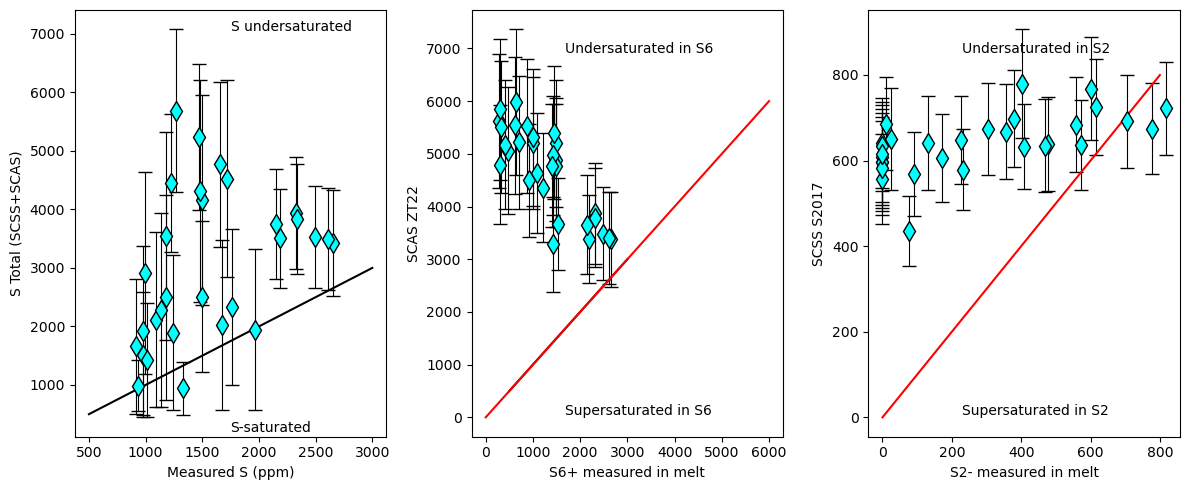

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

ax1.errorbar(S_types['S_ppm'],
         Stats_St['Mean_calc'], xerr=0, yerr=Stats_St['St_dev_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=5)
ax1.plot([500, 3000], [500, 3000], '-k')
ax2.plot([500, 3000], [500, 3000], '-k')
ax1.set_xlabel('Measured S (ppm)')
ax1.set_ylabel('S Total (SCSS+SCAS)')


  
    
ax2.errorbar((df_out['S6+/∑S'])*S_types['S_ppm'],
         Stats_S6['Mean_calc'], xerr=0, yerr=Stats_S6['St_dev_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=5)
        

ax2.plot([0, 6000], [0, 6000], '-r')
ax2.set_xlabel('S6+ measured in melt')
ax2.set_ylabel('SCAS ZT22')

ax3.errorbar((1-(df_out['S6+/∑S']))*S_types['S_ppm'],
         Stats_S2['Mean_calc'], xerr=0, yerr=Stats_S2['St_dev_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=5)
 

ax3.plot([0, 800], [0, 800], '-r')
ax3.set_xlabel('S2- measured in melt')
ax3.set_ylabel('SCSS S2017')
ax1.annotate("S-saturated", xy=(0.5, 0.01), xycoords="axes fraction", fontsize=10)
ax1.annotate("S undersaturated", xy=(0.5, 0.95), xycoords="axes fraction", fontsize=10)


ax2.annotate("Supersaturated in S6", xy=(0.3, 0.05), xycoords="axes fraction", fontsize=10)
ax2.annotate("Undersaturated in S6", xy=(0.3, 0.9), xycoords="axes fraction", fontsize=10)

ax3.annotate("Supersaturated in S2", xy=(0.3, 0.05), xycoords="axes fraction", fontsize=10)
ax3.annotate("Undersaturated in S2", xy=(0.3, 0.9), xycoords="axes fraction", fontsize=10)

fig.tight_layout()